In [26]:

import os
assert 'THEANO_FLAGS' in os.environ
# switch to cpu
os.environ['THEANO_FLAGS'] = 'floatX=float32,device=cpu,nvcc.fastmath=True'

import numpy as np
import os
import lasagne
import matplotlib.pyplot as plt

import convvisual.analysis.utils as cu
import convvisual.analysis.analysis as can
import convvisual.analysis.data_preparation as cdp

import convvisual.receptive_field.receptive_field
import convvisual.receptive_field as crf

from braindecode.veganlasagne.layers import create_pred_fn
import convvisual.analysis.plot_new as plot

import scipy
from scipy.signal import butter, lfilter, hilbert

plt.rcParams['figure.figsize'] = 10, 1

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
sampling_rate = 250.
src_layer = 22
# 11.90
phase = 0
hz = 11.6279069767

rf_size = 387

In [191]:
fs = sampling_rate
lowcut = 8#hz-0.32299742
highcut = 13#hz+0.32299742


modelpath = '/home/hartmank/braindecode/data/models/'
modelname = 'paper/ours/cnt/deep4/car/%d'%subject
savepath  = '/home/hartmank/data/convvisual/RF_data_paper/'
folder = 'FilterAnalysis_nUnits100'
datapath = os.path.join(savepath,modelname,folder)

In [165]:
def get_data(subject,src_filter_norm,channels):
    modelpath = '/home/hartmank/braindecode/data/models/'
    modelname = 'paper/ours/cnt/deep4/car/%d'%subject
    savepath  = '/home/hartmank/data/convvisual/RF_data_paper/'
    folder = 'FilterAnalysis_nUnits100'
    datapath = os.path.join(savepath,modelname,folder)

    RF_data = crf.receptive_field.load_ExtractorData(datapath)
    
    sensor_names = RF_data.sensor_names
    sensor_ind = np.where(np.in1d(sensor_names,channels))[0]

    model = lasagne.layers.get_all_layers(RF_data.model)
    input_shape = model[0].shape
    
    data = cdp.load_RF_data(datapath,src_layer,None,src_filter_norm)
    
    return data,model,sensor_ind,RF_data

In [115]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [116]:
gradient = np.ones((1000))

gradient1 = gradient.copy()
gradient1[450:550] = np.linspace(1,10,100)
gradient1[550:] = 10

gradient2 = gradient.copy()
gradient2[450:550] = np.linspace(1,10,100)[::-1]
gradient2[:450] = 10

gradient3 = gradient.copy()
gradient3[350:450] = np.linspace(1,10,100)
gradient3[550:650] = np.linspace(1,10,100)[::-1]
gradient3[450:550] = 10

def spindle_generator(window_size,spindle_size,gap_size,buildup_size):
    gradient = np.append(np.linspace(1,10,buildup_size),
                         np.append(10*np.ones((spindle_size-2*buildup_size)),
                         np.append(np.linspace(1,10,buildup_size)[::-1],
                                   np.ones((gap_size)))))
    while len(gradient)<window_size:
        gradient = np.append(gradient,gradient)
    return gradient[:window_size]
        
    
gradient4 = spindle_generator(1000,300,300,100)

In [117]:
subject = 22
src_filter = 8
channels = ['C3','CP3','CCP3h','CPP5h']
data,model,sensor_ind,RF_data = get_data(subject, src_filter, channels)

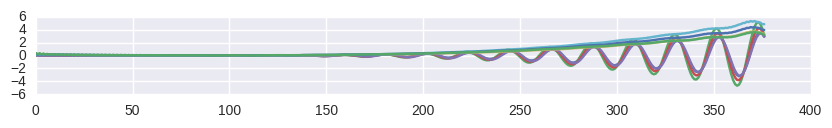

(4, 387) (128, 387)


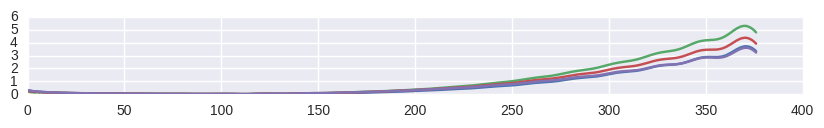

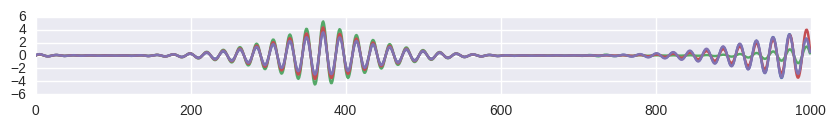

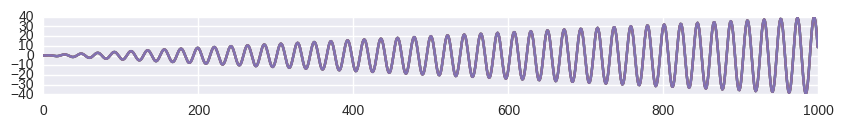

In [176]:
def merge_rev_curve(signal):
    signal_r = signal[::-1]
    bigger = signal[-1]<signal_r[1]
    for i in range(1,len(signal)/2):
        tmp_bigger = signal[-i+2]<signal_r[i+2]
        if tmp_bigger!=bigger:
            signal_merge = np.hstack([signal[:-i+2],signal_r[i+2:]])
            break
    return signal_merge
        

indeces = range(rf_size)
mean_data = np.median(data['X_RF_cropped'],axis=0)
input_ = np.hstack([mean_data[:,indeces],
                   np.hstack([mean_data[:,indeces[::-1]],
                             np.hstack([mean_data[:,indeces],
                                       mean_data[:,indeces[::-1]]])])])

x_filt = butter_bandpass_filter(data['X_RF_cropped'][:,sensor_ind,:].squeeze(), lowcut, highcut, fs, order=6).mean(axis=0)
scaler = 10./x_filt.sum(axis=1)
for i in range(len(x_filt)):
    x_filt[i] = x_filt[i] * scaler[i]
    
analytic_signal = hilbert(x_filt)
amplitude_envelope = np.abs(analytic_signal)
plt.plot(x_filt[:,5:-5].T)
plt.plot(amplitude_envelope[:,5:-5].T)
plt.show()
print x_filt.shape,mean_data.shape

test1 = scipy.signal.savgol_filter(amplitude_envelope[:,5:-5],9,2)[:1000]
plt.plot(test1.T)
plt.show()

t = 2*np.pi*np.arange(1000)/sampling_rate
input_merge = np.zeros((1,128,1000,1),dtype=np.float32)
merge_ind = None
for i,ind in enumerate(sensor_ind):
    if merge_ind is None:
        test1_merge = merge_rev_curve(test1[i])
        test2_merge = merge_rev_curve(test1_merge)
        test2_merge = merge_rev_curve(test2_merge)
        test2_merge = merge_rev_curve(test2_merge)
        test2_merge = merge_rev_curve(test2_merge)[:1000]
    input_merge[:,ind,:,0] = test2_merge*np.sin(hz*t)
#input_merge -= input_merge/2
    
plt.plot(input_merge[0,sensor_ind,:,0].T)
plt.show()

input_const = np.zeros((1,128,1000,1),dtype=np.float32)
for i,ind in enumerate(sensor_ind):
    tmp = test1[i]
    mi = np.argmin(tmp)
    ma = np.argmax(tmp)
    tmp[:mi] = tmp[mi]
    tmp[ma:] = tmp[ma]
    tmp = np.hstack([np.full((311),tmp[mi]),tmp,np.full((312),tmp[ma])]).astype(np.float32)[:1000]
    tmp = np.linspace(0,40,1000)
    input_const[:,ind,:,0] = tmp*np.sin(hz*t)
    
plt.plot(input_const[0,sensor_ind,:,0].T)
plt.show()

In [177]:
src_pred_fn = create_pred_fn(crf.convvisual.check_if_finalreshape_is_needed(model,src_layer)[0][-1])
src_output1 = src_pred_fn(list(input_merge))
src_output1 = src_output1.reshape(1,src_output1.shape[1],src_output1.shape[2],1)

src_pred_fn = create_pred_fn(crf.convvisual.check_if_finalreshape_is_needed(model,src_layer)[0][-1])
src_output2 = src_pred_fn(list(input_const))
src_output2 = src_output2.reshape(1,src_output2.shape[1],src_output2.shape[2],1)

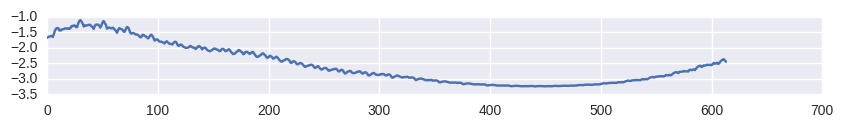

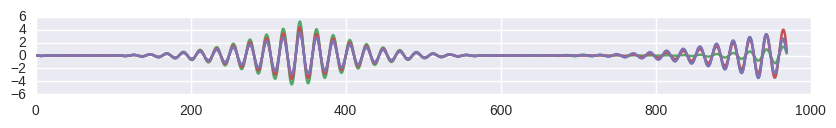

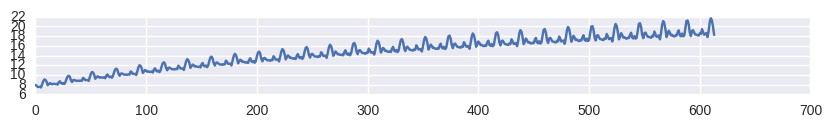

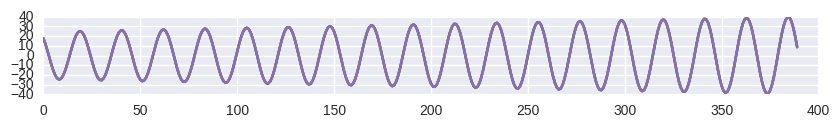

In [178]:
plt.plot(src_output1[0,src_filter,:,0])
plt.show()

plt.plot(input_merge[0,sensor_ind,np.argmax(src_output1[0,src_filter,:,0]):,0].T)
plt.show()

plt.plot(src_output2[0,src_filter,:,0])
plt.show()

plt.plot(input_const[0,sensor_ind,np.argmax(src_output2[0,src_filter,:,0]):,0].T)
plt.show()

In [127]:
filt_data = crf.receptive_field.load_FilterData(datapath,src_layer,None,src_filter)

In [129]:
extra_data = crf.receptive_field.load_ExtractorData(datapath)

In [130]:
units = filt_data.max_units_in_filters

In [172]:
x_filt.shape

(4, 1000)

In [132]:
extra_data.inputs.shape

(1790, 128, 1000, 1)

In [187]:
src_pred_fn = create_pred_fn(crf.convvisual.check_if_finalreshape_is_needed(model,src_layer)[0][-1])
src_output3 = src_pred_fn(list(extra_data.inputs[units[:,0]]))
src_output3 = src_output3.reshape(len(units[:,0]),src_output3.shape[1],src_output3.shape[2],1)

In [188]:
tmp_in = extra_data.inputs[units[:,0]]
tmp_in[:,np.in1d(range(128),sensor_ind)==False,:,:] = 0
src_output4 = src_pred_fn(list(tmp_in))
src_output4 = src_output4.reshape(len(units[:,0]),src_output4.shape[1],src_output4.shape[2],1)

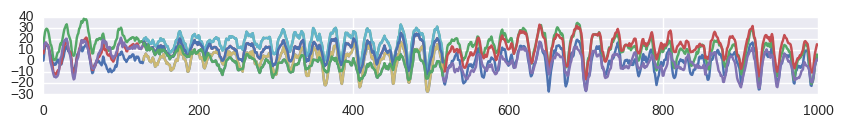

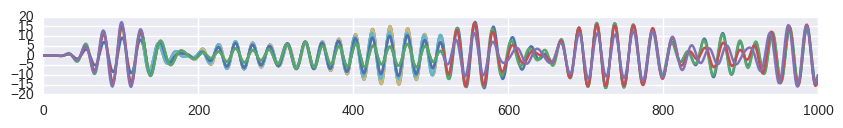

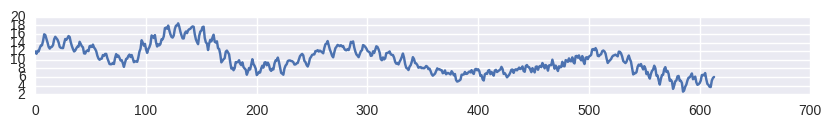

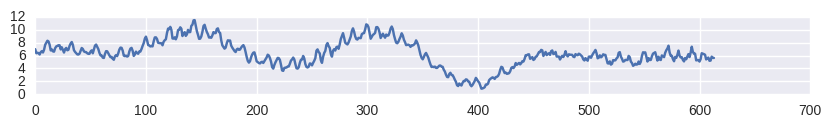

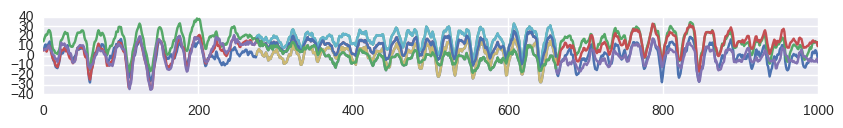

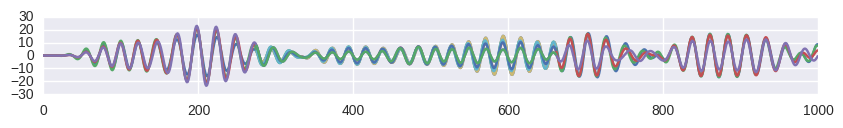

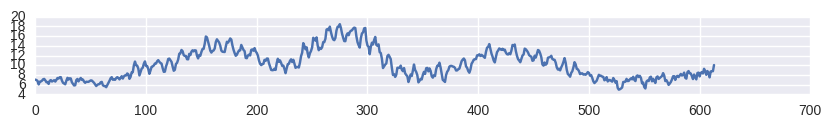

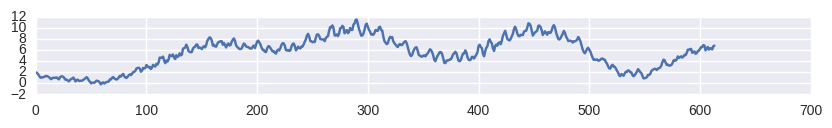

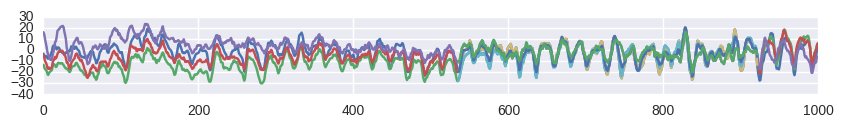

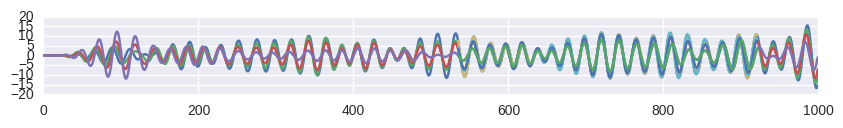

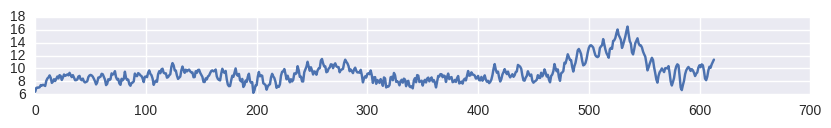

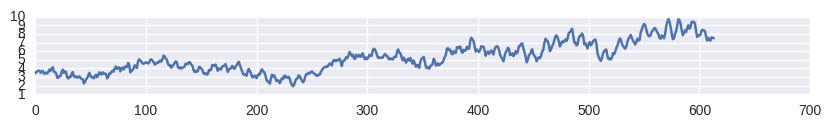

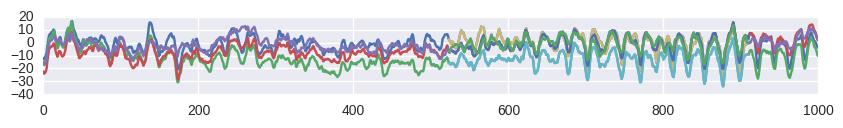

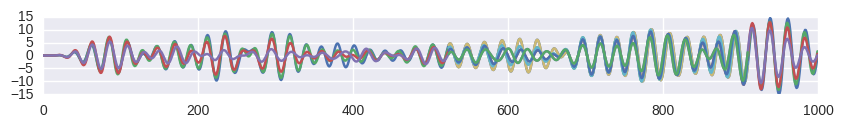

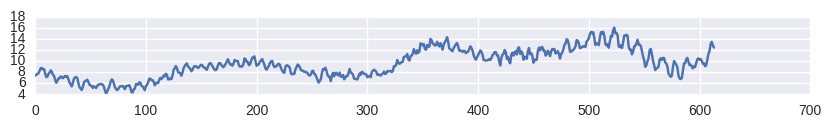

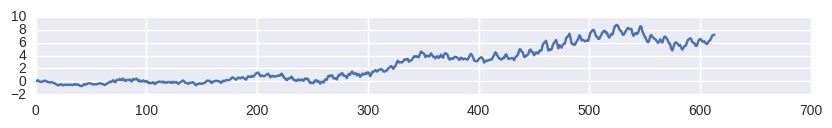

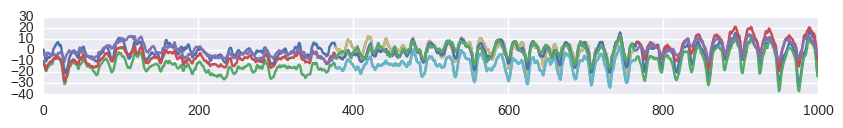

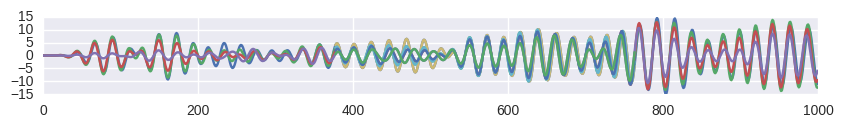

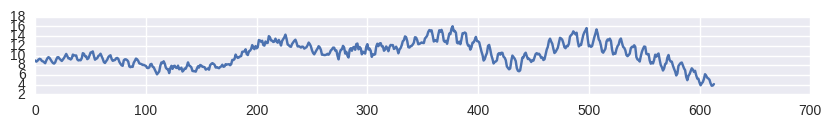

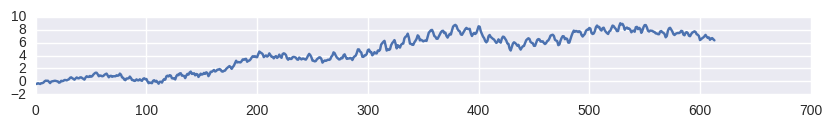

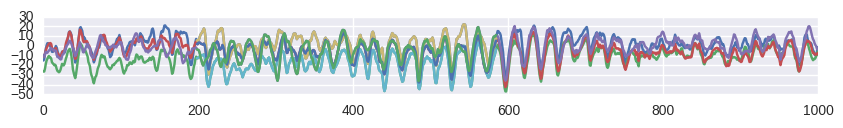

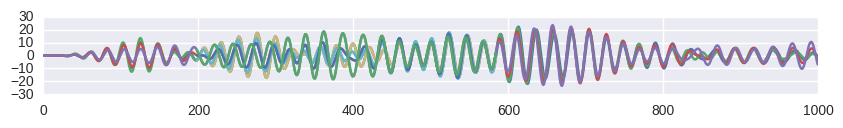

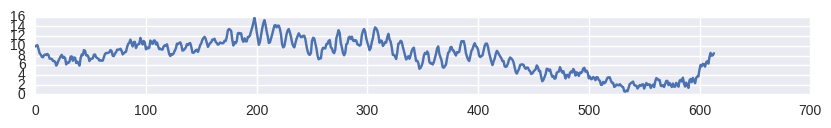

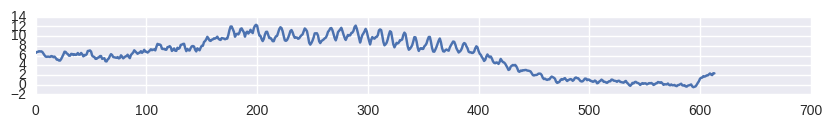

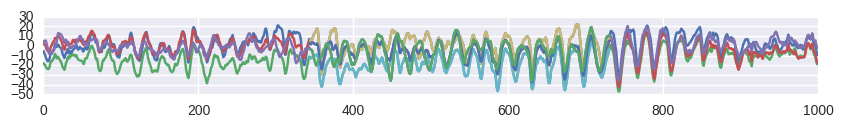

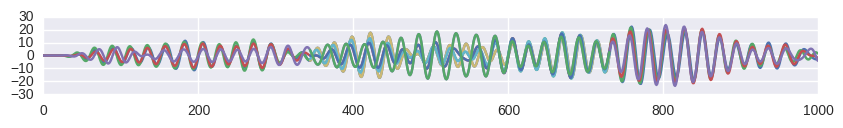

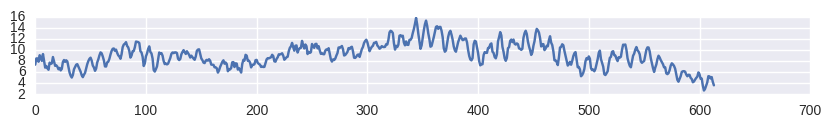

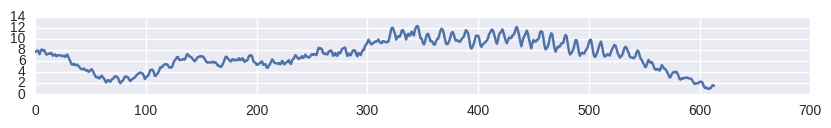

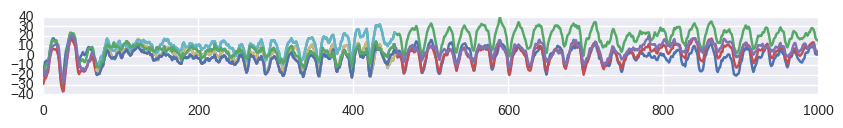

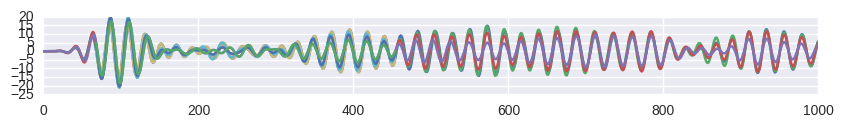

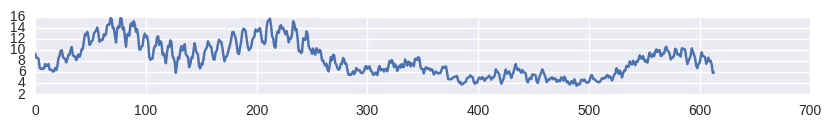

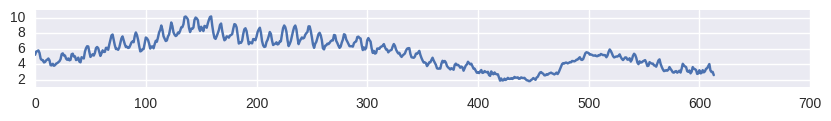

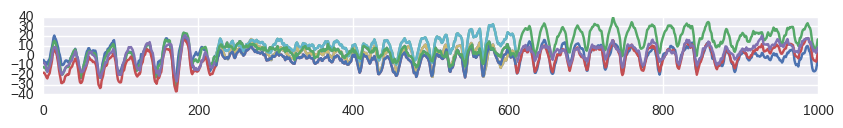

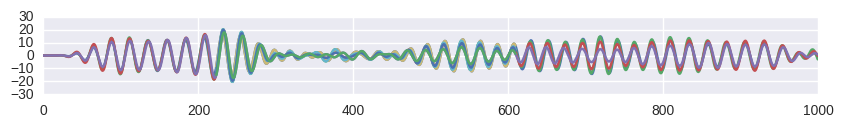

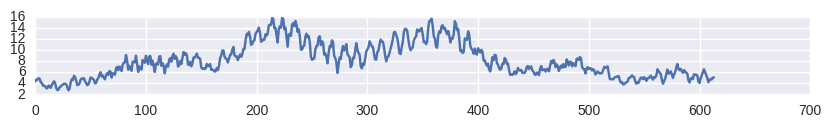

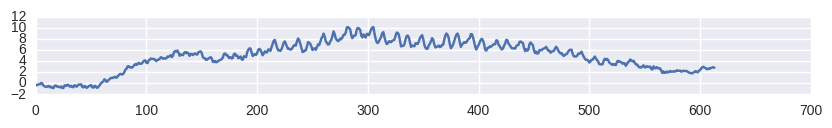

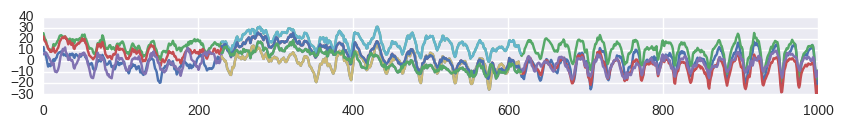

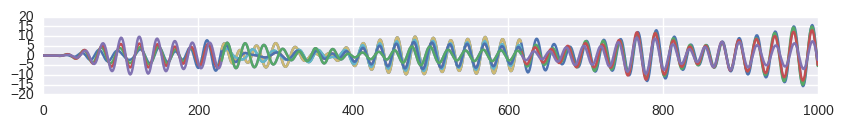

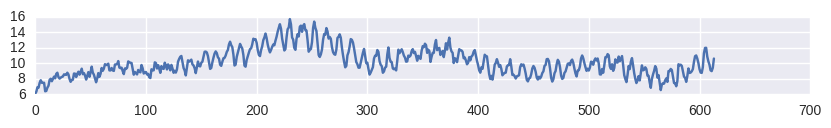

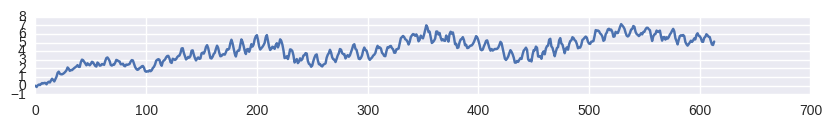

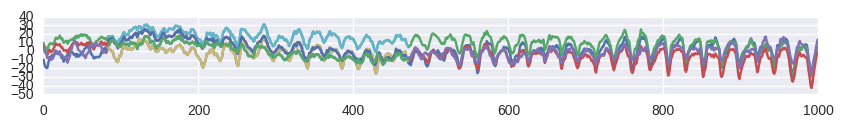

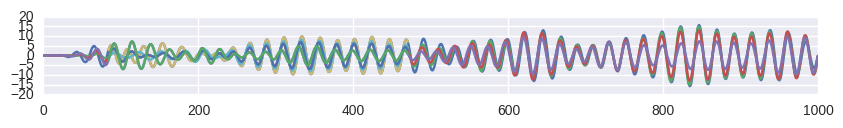

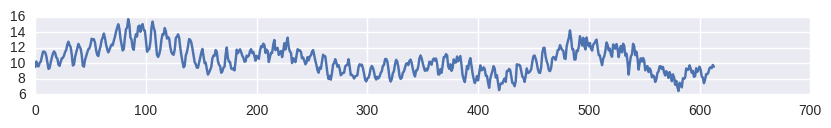

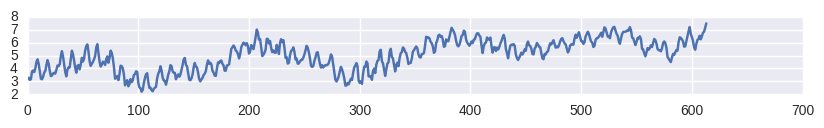

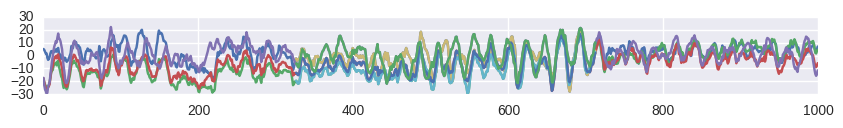

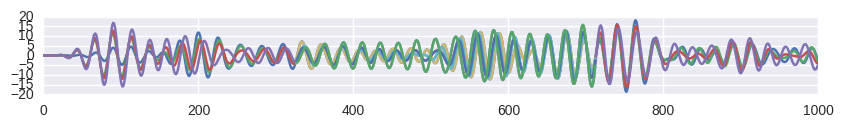

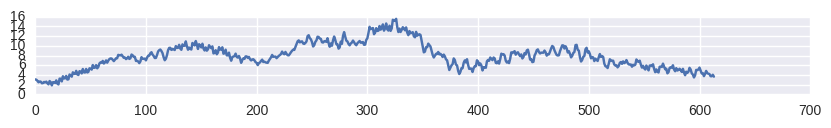

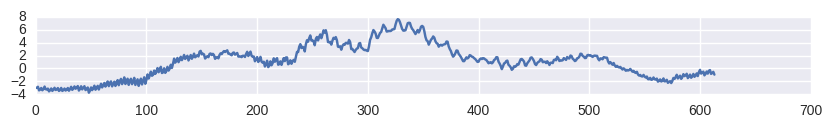

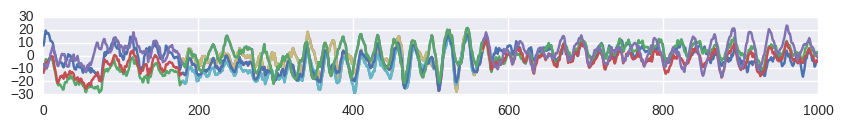

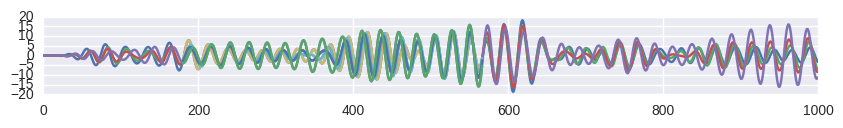

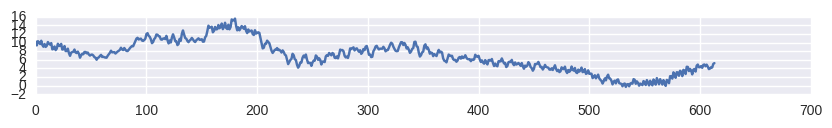

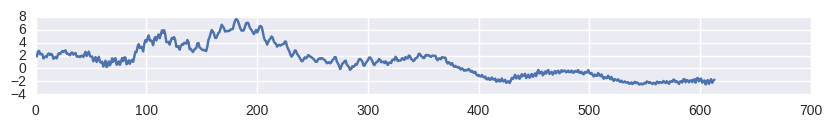

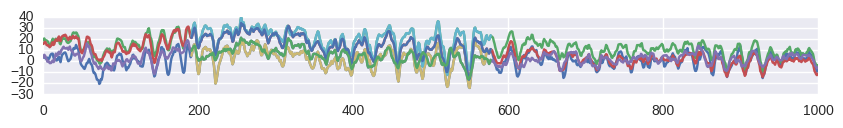

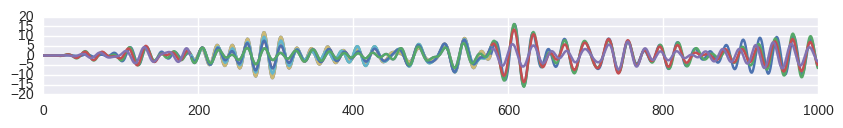

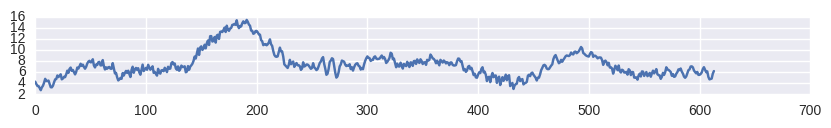

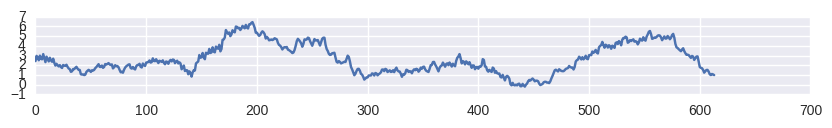

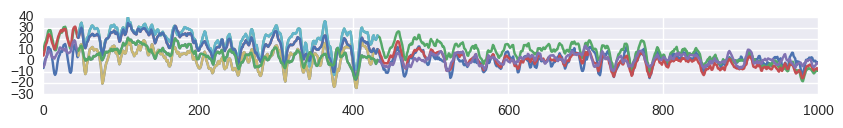

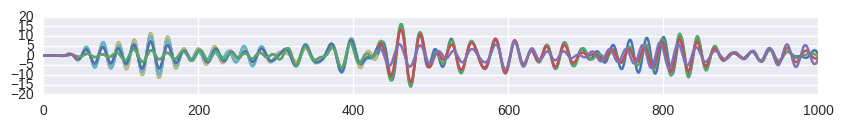

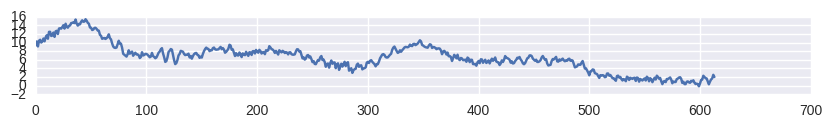

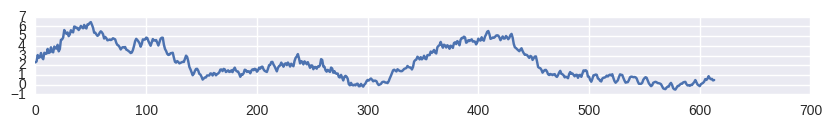

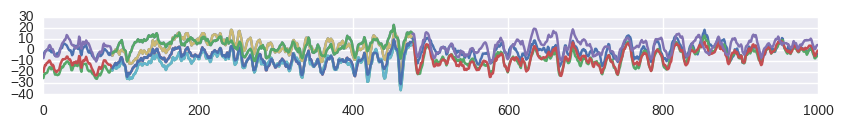

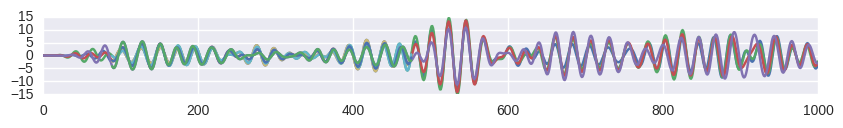

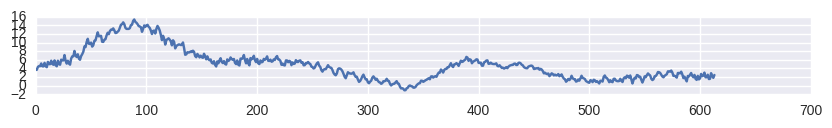

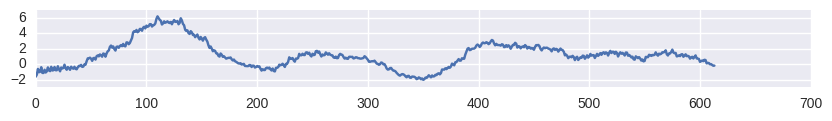

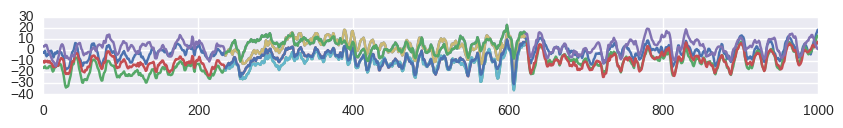

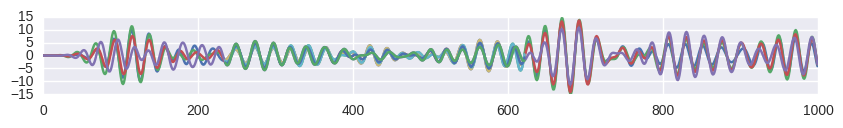

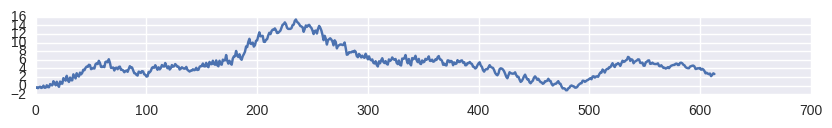

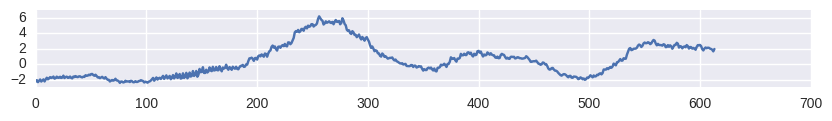

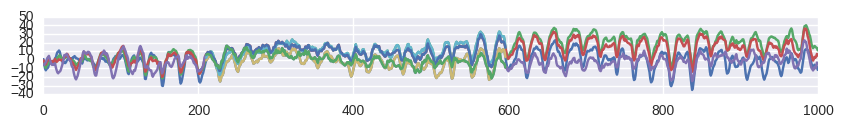

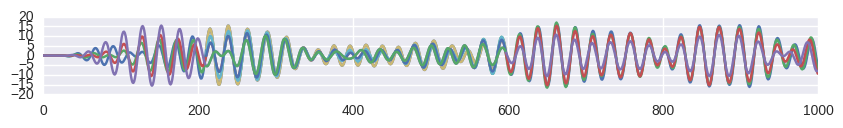

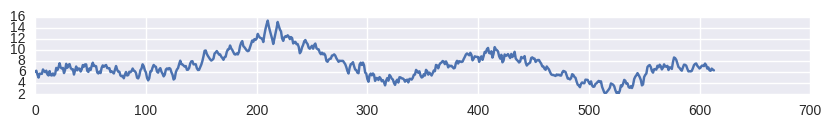

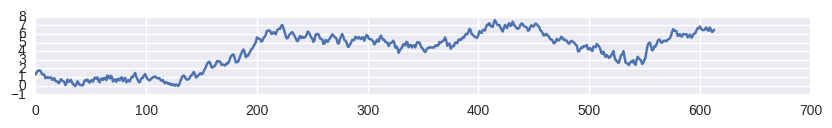

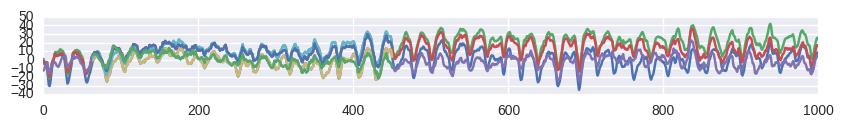

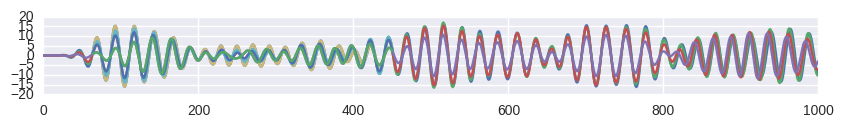

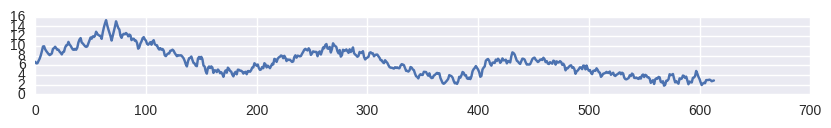

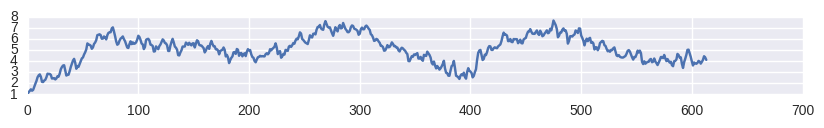

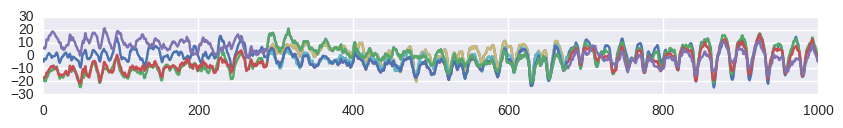

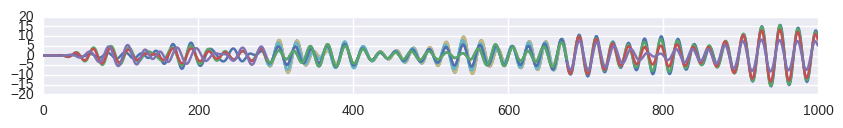

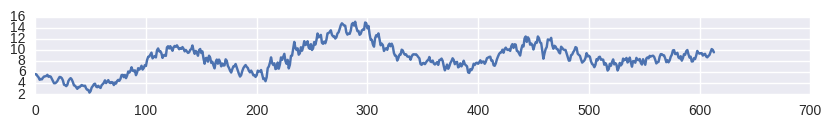

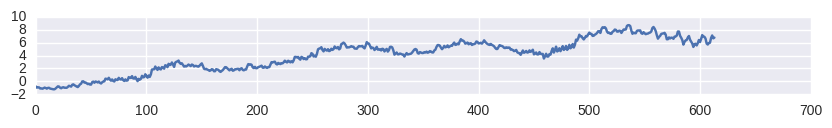

In [192]:
for i in range(20):
    plt.plot(extra_data.inputs[units[i,0],sensor_ind,:,0].T)
    plt.plot(range(units[i,2],units[i,2]+rf_size),extra_data.inputs[units[i,0],sensor_ind,units[i,2]:units[i,2]+rf_size,0].T)
    plt.show()
    
    x_filt = butter_bandpass_filter(extra_data.inputs[units[i,0],sensor_ind,:,0].squeeze(), lowcut, highcut, fs, order=6)
    plt.plot(x_filt[:,:].T)
    plt.plot(range(units[i,2],units[i,2]+rf_size),x_filt[:,units[i,2]:units[i,2]+rf_size].T)
    plt.show()
    
    plt.plot(src_output3[i,src_filter,:,0])
    plt.show()
    plt.plot(src_output4[i,src_filter,:,0])
    plt.show()

In [190]:
import numpy.fft
numpy.fft.fftfreq(387, d=1/250.)

#print (11.62790698-10.98191214)/2

array([   0.        ,    0.64599483,    1.29198966,    1.9379845 ,
          2.58397933,    3.22997416,    3.87596899,    4.52196382,
          5.16795866,    5.81395349,    6.45994832,    7.10594315,
          7.75193798,    8.39793282,    9.04392765,    9.68992248,
         10.33591731,   10.98191214,   11.62790698,   12.27390181,
         12.91989664,   13.56589147,   14.2118863 ,   14.85788114,
         15.50387597,   16.1498708 ,   16.79586563,   17.44186047,
         18.0878553 ,   18.73385013,   19.37984496,   20.02583979,
         20.67183463,   21.31782946,   21.96382429,   22.60981912,
         23.25581395,   23.90180879,   24.54780362,   25.19379845,
         25.83979328,   26.48578811,   27.13178295,   27.77777778,
         28.42377261,   29.06976744,   29.71576227,   30.36175711,
         31.00775194,   31.65374677,   32.2997416 ,   32.94573643,
         33.59173127,   34.2377261 ,   34.88372093,   35.52971576,
         36.17571059,   36.82170543,   37.46770026,   38.11369